In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import edhec_risk_kit as erk

In [2]:
ind = erk.get_ind_returns()
ind.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0083,0.0922,0.0206,0.0770,0.0193,-0.2379,0.0007,0.0187,0.0037,0.0520
1926-08,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0814,...,0.0217,0.0202,0.0439,-0.0238,0.0488,0.0539,-0.0075,-0.0013,0.0446,0.0676
1926-09,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0231,...,0.0241,0.0225,0.0019,-0.0554,0.0005,-0.0787,0.0025,-0.0056,-0.0123,-0.0386
1926-10,-0.0306,-0.0331,0.0106,-0.0476,0.0947,-0.0468,0.0012,-0.0057,-0.0476,0.0100,...,-0.0011,-0.0200,-0.0109,-0.0508,-0.0264,-0.1538,-0.0220,-0.0411,-0.0516,-0.0849
1926-11,0.0635,0.0729,0.0455,0.0166,-0.0580,-0.0054,0.0187,0.0542,0.0520,0.0311,...,0.0163,0.0377,0.0364,0.0384,0.0160,0.0467,0.0652,0.0433,0.0224,0.0400


<AxesSubplot:>

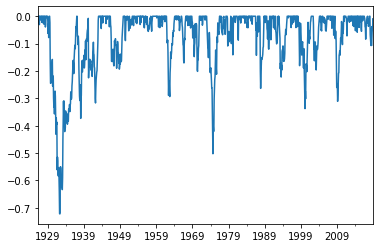

In [6]:
erk.drawdown(ind['Food'])['Drawdown'].plot()

# Efficient Frontier

To compute the efficient frontier we need expected returns and the covariance between assets. The naive approach is to estimate these parameters using historic data.

<AxesSubplot:>

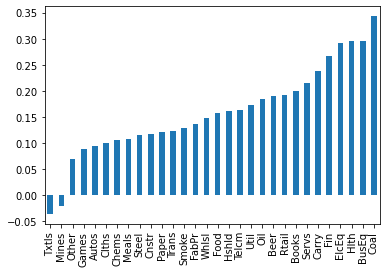

In [10]:
er = erk.annualize_rets(ind["1995": "2000"], 12)
er.sort_values().plot.bar()

In [24]:
cov = ind["1995":"2000"].cov()

In [54]:
def portfolio_return(w, r):
    return w.T @ r

def portfolio_vol(w, cov):
    return (w.T @ cov @ w)**0.5

In [16]:
l = ['Food', 'Beer', 'Smoke', 'Coal']
er[l]

Food     0.157362
Beer     0.190134
Smoke    0.129288
Coal     0.343089
dtype: float64

In [19]:
cov.loc[l, l]

,Food,Beer,Smoke,Coal
Food,0.002287,0.002077,0.001757,0.000034
Beer,0.002077,0.004599,0.001143,0.001261
Smoke,0.001757,0.001143,0.007130,-0.000544
Coal,0.000034,0.001261,-0.000544,0.016153


In [22]:
w = np.ones(4,) * 1/4
portfolio_return(w, er[l])

0.20496820684146116

In [23]:
portfolio_vol(w, cov.loc[l,l])

0.05100412722141178

## 2-asset efficient frontier

<AxesSubplot:xlabel='Vol', ylabel='R'>

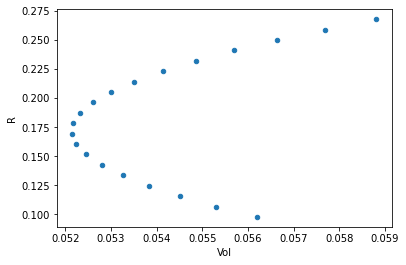

In [36]:
l = ['Games', 'Fin']
n = 20
w1 = np.arange(0, 1, 1/n)
w2 = 1 - w1
weights = np.array([w1, w2]).T

rets = np.array([portfolio_return(w, er[l]) for w in weights])
vols = np.array([portfolio_vol(w, cov.loc[l, l]) for w in weights])
ef = pd.DataFrame({'R': rets, 'Vol': vols})
ef.plot.scatter(x='Vol', y='R')

<AxesSubplot:xlabel='Volatility'>

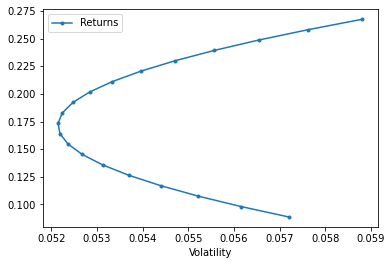

In [40]:
erk.plot_ef2(20, er[l], cov.loc[l,l])

## N-asset efficient frontier

In [41]:
from scipy.optimize import minimize

In [44]:
def minimize_vol(target_return, er, cov):
    n = er.shape[0]
    init_w = np.ones(n,)/n
    bounds = ((0.0, 1.0),)*n
    return_is_target = {
        'type': 'eq', # **eq**ual to 0
        'args': (er,),
        'fun': lambda weights, er: target_return - portfolio_return(weights, er)
    }
    weights_sum_to_1 = {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights) - 1
    }
    results = minimize(portfolio_vol, init_w,
                      args=(cov,), method='SLSQP',
                      options={'disp': False},
                      constraints=(return_is_target, weights_sum_to_1),
                      bounds=bounds)
    return results.x

In [48]:
w15 = minimize_vol(.15, er[l], cov.loc[l,l])
vol15 = portfolio_vol(w15, cov.loc[l,l])
vol15

0.05250418123905939

In [74]:
def optimal_weights(n, er, cov):
    # the target returns will lie somewhere between worst performing asset and best performing,
    # this defines lower and upper bounds of the efficient frontier
    target_rs = np.linspace(er.min(), er.max(), n)
    # for every target return we try to find a portfolio with min volatility
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights
    
def plot_ef(n, er, cov):
    weights = optimal_weights(n, er, cov)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        'Returns': rets,
        'Volatility': vols
    })
    return ef.plot.line(x='Volatility', y='Returns', style='.-')

<AxesSubplot:xlabel='Volatility'>

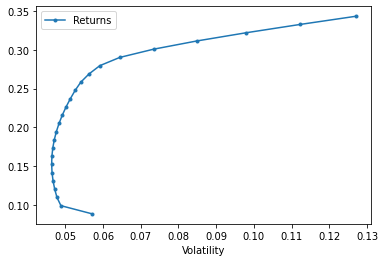

In [75]:
l = ['Smoke','Fin','Games', 'Coal']
plot_ef(25, er[l], cov.loc[l,l])